# **UCI dataset**
## **Εισαγωγή και επισκόπηση**
### Libraries/Dependencies Import

In [29]:
# Basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time

# scikit-learn 

## models
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

## data preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

## Grid Search
from sklearn.model_selection import GridSearchCV

#warnings
import warnings
# warnings.filterwarnings('ignore')

### Παρουσίαση Dataset
All the patients suffered heart attacks at some point in the past. Some are still alive and some are not.  The survival and still-alive variables, when taken together, indicate whether a patient survived for at least one year following the heart attack.  
The problem addressed by past researchers was to predict from the other variables whether or not the patient will survive at least one year.  The most difficult part of this problem is correctly predicting that the patient will NOT survive.  (Part of the difficulty seems to be the size of the data set.)

### Εισαγωγή Dataset
Για την σωστή εισαγωγή του dataset έπρεπε να προσθέσουμε ένα header με τις ονομασίες των features καθώς δεν προυπήρχαν. 

In [30]:
data = pd.read_csv('/kaggle/input/echocardiogram/echocardiogram.data')
data # Dataframe

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,7.5,1,64,0,0.24,12.9,4.72,12,1,0.857,name,?,?
128,41,0,64,0,0.28,5.40,5.47,11,1.10,0.714,name,?,?
129,36,0,69,0,0.20,7.00,5.05,14.5,1.21,0.857,name,?,?
130,22,0,57,0,0.14,16.1,4.36,15,1.36,0.786,name,?,?


## **Χαρακτηριστικά**
Το dataset περιέχει **132 δείγματα** συνολικά και έχει **12 features** ανά δείγμα καθώς η τελευταία στήλη αποτελεί το σύνολο των labels.

### Είδος Χαρακτηριστικών
**Continuous**
- survival 
- age-at-heart-attack
- fractional-shortening
- epss
- lvdd
- wall-motion-score
- wall-motion-index

**Categorical**
- still-alive
- pericardial-effusion
- alive-at-1

**Ignore**
- mult
- name
- group

### Διαγραφή Χαρακτηριστικών
Υπάρχουν τρία χαρακτηριστικά τα οποία δεν χρειάζεται να χρησιμοποιηθούν κατά το training του μοντέλου, όπως αναφέρεται και στη σελίδα του UCI. 

### Επικεφαλίδες και αρίθμηση γραμμών
Τις επικεφαλίδες τις προσθέσαμε χειροκίνητα και με τη χρήση του pandas dataframe έχουμε αρίθμηση στις γραμμές μας

### Ετικέτες Κλάσεων
Η κλάση του dataset βρίσκεται στη τελευταία στήλη και ονομάζεται `alive-at-1`. Μπορεί να πάρει δύο τιμές 0 ή 1. Στη περίπτωση που ο ασθενής απεβίωσε τους πρώτους 12 μήνες από το καρδιακό επεισόδιο τότε λαμβάνει 1 ως τιμή και 0 σε αντίθετη περίπτωση.

In [31]:
print(data.shape) # Dataset total values & attributes
data = data.drop(['mult', 'name', 'group'],axis=1) # Features Drop

(132, 13)


## **Προεπεξεργασία Δεδομένων**

### Απουσιάζουσες τιμές
Στο dataset υπάρχουν αρκετές απουσιάζουσες τιμές και αυτό το παρατηρούμε αντικαθιστώντας όσες τιμές είναι με ερωτηματικό ('?') με το NaN. Στο σύνολο των δεδομένων μας έχουμε συνολικά 106 απουσιάζουσες τιμές και αποτελούν το 8% του συνόλου των δεδομένων. 

*Στη πρώτη στήλη υπάρχουν συνολικά δύο απουσιάζουσες τιμές για τις οποίες δεν μπορούμε να εξάγουμε συμπεράσματα δηλαδή εάν απεβίωσε ο ασθενής ή όχι και για αυτό τις διαγράφουμε. Δεν αποτελούν σημαντικό στατιστικό δέιγμα για το σύνολο των δεδομένων και δεν θα έχει επιρροή στο τρέξιμο των μοντέλων.

In [32]:
# Replace '?' with NaN
data = data.replace('?',np.nan)
# Total missing values
missing_values = data.isnull().sum().sum()
print(missing_values)
# Percentage of missing values
total_values = data.size
print(round(missing_values/total_values * 100,2), "%")

106
8.03 %


In [33]:
# Delete rows for which their first attribute 'survival' have NaN values
data = data.dropna(subset=['survival'])
print(data.shape)

(130, 10)


### Πλήθος Κλάσεων και διαχείριση
Παρατηρούμε ότι υπάρχουν απουσιάζουσες τιμές στη στήλη των κλάσεων κάτι που δεν είναι επιθυμητό και μπορεί να αντιμετωπιστεί καθώς η τιμή τους εξαρτάται από το feature 'survival'. Πριν το κάνουμε όμως αυτό θα χρειαστεί να τροποποιήσουμε τα types των χαρακτηριστικών ώστε να μην έχουμε θέμα κατά τη σύγκριση των τιμών.

Μετά από τη μετατροπή εισάγουμε τις κατάλληληλες τιμές στη στήλη των labels και ελέγχουμε τα ποσοστά δειγμάτων επί του σύνολου. Παρατηρούμε ότι η αναλογία είναι **67/33** συνεπώς το dataset θεωρείται **unbalanced**.

In [34]:
# We create a dictionary for the features 
d_types = {
    'survival': np.float64,
    'still-alive': np.float64,
    'age-at-heart-attack': np.float64,
    'pericardial-effusion': np.float64,
    'fractional-shortening': np.float64,
    'epss': np.float64,
    'lvdd': np.float64,
    'wall-motion-score': np.float64,
    'wall-motion-index': np.float64,
    'alive-at-1': np.float64
}

data = data.astype(d_types)

### Έλεγχος αξιοπιστίας δεδομένων
Γνωρίζουμε ότι εάν ο ασθενής έχει επιζήσει μέχρι 12 μήνες μέχρι το συμβάν (survival <=12) και ακόμα είναι ζωντανος (still-alive=1) τότε αυτά τα δεδομένα δεν είναι χρήσιμα για την εκπαίδευση των μοντέλων. Στο σύνολό τους είναι 34.

In [35]:
# Check whether <12 and still-alive
#data[(data['survival'] <= 12) & (data['still-alive'] == 1)].shape[0]

In [36]:
# Delete rows 
#data = data.drop(data[(data['survival'] <= 12) & (data['still-alive'] == 1)].index)

In [37]:
data['alive-at-1'] = np.where(data['survival'] <= 12, 1, data['alive-at-1'])
data['alive-at-1'] = np.where(data['survival'] > 12, 0, data['alive-at-1'])

# Check whether balanced or unbalanced
total_1 = data[data['alive-at-1'] == 1].count()['alive-at-1']
total_0 = data[data['alive-at-1'] == 0].count()['alive-at-1']
print(round(total_0/data.shape[0] * 100, 2), "%")
print(round(total_1/data.shape[0] * 100, 2), "%")

67.69 %
32.31 %


### Διαχείριση απουσιάζουσων τιμών και διατεταγμένων χαρακτηριστικών
Με τη βοήθεια της pandas θα αντικαταστήσουμε κάθε απουσιάζουσα τιμή χαρακτηριστικού με τη μέση τιμή για συνεχείς μεταβλητές στο 
train set. Παρατηρούμε ότι δεν έχουμε απουσιάζουσες τιμές για τα κατηγορικά δεδομένα.

Παρατηρούμε επίσης ότι στο σύνολο των δεδομένων δεν χρειάζεται ειδική διαχείριση των κατηγορικών δεδομένων καθώς δεν είναι σε μορφή str. Επιπλέον το dataset μας δεν έχει κατηγορικά δεδομένα που είναι μη διατεταγμένα.

In [38]:
# Define the continuous features
continuous_col = ['survival','age-at-heart-attack', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score', 'wall-motion-index']

# Impute the dataset
for col in continuous_col:
    data[col].fillna(data[col].mean(), inplace=True)

In [39]:
data.isnull().sum()

survival                 0
still-alive              0
age-at-heart-attack      0
pericardial-effusion     0
fractional-shortening    0
epss                     0
lvdd                     0
wall-motion-score        0
wall-motion-index        0
alive-at-1               0
dtype: int64

## Μετατροπή σε numpy arrays και χωρισμός των δεδομένων
Χωρίζουμε τα δεδομένα σε δύο πίνακες labels και features. Ο πρώτος περιέχει όλες τις τιμές των label για όλα τα διανύσματα των χαρακτηριστικών και ο πίνακας features εκείνα τα χαρακτηριστικά που χρειαζόμαστει για να κάνουμε train το μοντέλο τα οποία βρίσκονται από τη 2η μέχρι την 9η στήλη. 

In [40]:
labels_df = data.iloc[:,-1] # labels in the last column
features_df = data.iloc[:,2:9] # rest of the features 

# Convert to numpy arrays
np_labels = labels_df.values
np_features = features_df.values

In [41]:
# Split our data
train, test, train_labels, test_labels = train_test_split(np_features, np_labels, test_size=0.3, random_state=0)

In [42]:
print(train.shape)
print(test.shape)

(91, 7)
(39, 7)


In [43]:
print(train.size)

637


# **Ταξινόμηση**

Σε όλα τα πειράματα χρησιμοποιούμε 10-fold cross-validation.

## **Out-of-the-box (Χωρίς Βελτιστοποίηση)**
Αρχικά θα δούμε πως συμπεριφέρονται οι ταξινομητές χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε default τιμές.

### Dummy Classifier

In [44]:
model_dc = DummyClassifier().fit(train, train_labels) # training
pred_dc =  model_dc.predict(test) # prediction
accuracy_dc = model_dc.score(test, test_labels ) # accuracy
f1_dc = f1_score(test_labels, pred_dc, average='weighted') # f1 score
print("Accuracy Score: ", round(accuracy_dc, 4) * 100, "%")
print("F1 Score: ", round(f1_dc, 4) * 100, "%")

Accuracy Score:  58.97 %
F1 Score:  43.76 %


### Gaussian Naive Bayes (GNB)

In [45]:
model_gnb = GaussianNB().fit(train, train_labels)
pred_gnb = model_gnb.predict(test)
accuracy_gnb = model_gnb.score(test, test_labels)
f1_gnb = f1_score(test_labels, pred_gnb, average='weighted')
print("Accuracy Score: ", round(accuracy_gnb, 4) * 100, "%")
print("F1 Score: ", round(f1_gnb, 4) * 100, "%")

Accuracy Score:  64.1 %
F1 Score:  60.78 %


### KNearestNeighbors (kNN)

In [46]:
model_knn = KNeighborsClassifier().fit(train, train_labels)
pred_knn = model_knn.predict(test)
accuracy_knn = accuracy_score(test_labels, pred_knn)
f1_knn = f1_score(test_labels, pred_knn, average='weighted')
print("Accuracy Score: ", round(accuracy_knn, 4) * 100, "%")
print("F1 Score: ", round(f1_knn, 4) * 100, "%")

Accuracy Score:  61.53999999999999 %
F1 Score:  55.17999999999999 %


### Logistic Regression (LR)

In [47]:
model_lr = LogisticRegression(max_iter=150).fit(train, train_labels)
pred_lr = model_lr.predict(test)
accuracy_lr = accuracy_score(test_labels, pred_lr)
f1_lr = f1_score(test_labels, pred_lr, average='weighted')
print("Accuracy Score: ", round(accuracy_lr, 4) * 100, "%")
print("F1 Score: ", round(f1_lr, 4) * 100, "%")

Accuracy Score:  61.53999999999999 %
F1 Score:  55.17999999999999 %


### Πίνακας Markdown

| Estimator | Accuracy Score | F1 Score |
| :--------- | -------------- | -------- |
| Dummy Classifier | 61.53% | 46.89% |
| Gaussian Naive Bayes | 71.78% |  67.97% | 
| K Neirest Neighbors | 64.1% | 60.14% | 
| Logistic Regression  | 61.53% |  53.99% |

### Bar Plot

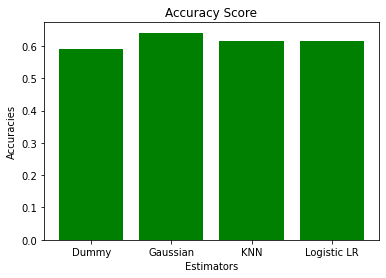

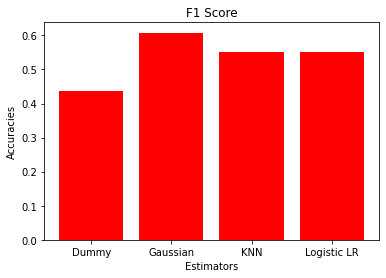

In [48]:
# Accuracy Score
estimators = ["Dummy", "Gaussian", "KNN", "Logistic LR"]
accuracies = [accuracy_dc, accuracy_gnb, accuracy_knn, accuracy_lr]

plt.bar(estimators, accuracies, color='green')
plt.xlabel("Estimators")
plt.ylabel("Accuracies")
plt.title("Accuracy Score")
plt.show()

# F1 Score
accuracies = [f1_dc, f1_gnb, f1_knn, f1_lr]

plt.bar(estimators,accuracies, color='red')
plt.xlabel("Estimators")
plt.ylabel("Accuracies")
plt.title("F1 Score")

plt.show()

### Συμπέρασμα
Φαίνεται ξεκάθαρα ότι ο καλύτερος ταξινομητής στη προκειμένη περίπτωση, χρησιμοποιώντας απλά τις default τιμές, είναι ο Logistics Regression.

## **Με Βελτιστοποίηση**
### Προεπεξεργασία Δεδομένων
Έχουμε ήδη διαχειριστεί τις απουσιάζουσες τιμές του dataset ενώ δεν χρειάζονται κάποια ειδική διαχείριση τα κατηγορικά χαρακτηριστικά.

Χρησιμοποιούμε τις εξής μεθόδους προεπεργασίας δεδομένων (Transformers): 
- Μείωση διαστάσεων εισόδου χρησιμοποιώντας τη συνάρτηση **VarianceThreshold**
- Κανονικοποίηση χαρακτηριστικών με **StandardScaler**
- Εξισορροπηστής δεδομένων  **RandomOverSampler**
- Εξαγωγή χαρακτηριστικών με **PCA**

In [49]:
# Transformers
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()

# One pipe for every classifier

## Dummy Classifier
steps_dc = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('estimator', DummyClassifier())]
pipe_dc = Pipeline(steps=steps_dc)

## Gaussian Naive Bayes
steps_gnb = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('estimator', GaussianNB())]
pipe_gnb = Pipeline(steps=steps_gnb)

## K-nearest Neighbor
steps_knn = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('estimator', KNeighborsClassifier(n_jobs=-1))]
pipe_knn = Pipeline(steps=steps_knn)

## Logistic Regression
steps_lr = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('estimator', LogisticRegression(n_jobs=-1))]
pipe_lr = Pipeline(steps=steps_lr)

### Πεδίο Ορισμού Υπερπαραμέτρων Μετασχηματιστών

In [50]:
# Check feature variance
train_variance = train.var(axis=0)
print(train_variance)
print(np.max(train_variance))
print(np.min(train_variance))

[6.08603495e+01 1.30177515e-01 1.20200213e-02 4.98918606e+01
 5.78289434e-01 2.63018115e+01 2.20503075e-01]
60.86034954543202
0.01202002129417956


In [51]:
# Define  transfoermers hyperparameters domain

## VarianceThreshold
vthreshold = [0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50]

## PCA
n_components = [1] 

### Πεδίο Ορισμού Υπερπαραμέτρων Ταξινομητών

In [52]:
## Dummy Classifier
strategy = ['most_frequent', 'prior', 'stratified', 'uniform']

## Gaussion Naive Bayes
var_smoothing= [1e-9, 1e-5, 1e-3, 1]

## K-Nearest Neighbor
k_nearest = [1, 6, 11, 21, 31, 41]
metric = ['euclidean', 'manhattan', 'minkowski']

## Logistic Regression
max_iter = [100, 200, 300]
penalty = ['l2']

## **Accuracy**

Ορισμός Ταξινομητών: 

In [53]:
## Dummy Classifier
estimator_dc = GridSearchCV(pipe_dc, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__strategy=strategy), cv=10, scoring='accuracy', n_jobs=-1)

## Gaussian Naive Bayes
estimator_gnb = GridSearchCV(pipe_gnb, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__var_smoothing=var_smoothing), cv=10, scoring='accuracy', n_jobs=-1)

## K-Nearest Neighbors
estimator_knn = GridSearchCV(pipe_knn, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__n_neighbors=k_nearest, estimator__metric=metric), 
                                          cv=10, scoring='accuracy', n_jobs=-1)

## Logistic Regression
estimator_lr = GridSearchCV(pipe_lr, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__max_iter=max_iter, estimator__penalty=penalty), 
                                          cv=10, scoring='accuracy', n_jobs=-1)

### Προσδιορισμός βέλτιστων υπερπαραμέτρων 

In [54]:
# Dummy Classifier 
start_time = time.time()
estimator_dc.fit(train, train_labels)
preds_dc = estimator_dc.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_dc))
print(estimator_dc.best_estimator_)
print(estimator_dc.best_params_)

opt_accuracy_dc = accuracy_score(test_labels, preds_dc)

Συνολικός χρόνος fit και predict: 2.4349396228790283 seconds
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74        23
         1.0       0.00      0.00      0.00        16

    accuracy                           0.59        39
   macro avg       0.29      0.50      0.37        39
weighted avg       0.35      0.59      0.44        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator', DummyClassifier(strategy='most_frequent'))])
{'estimator__strategy': 'most_frequent', 'pca__n_components': 1, 'selector__threshold': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# Gaussian Naive Bayes 
start_time = time.time()
estimator_gnb.fit(train, train_labels)
preds_gnb = estimator_gnb.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_gnb))
print(estimator_gnb.best_estimator_)
print(estimator_gnb.best_params_)

opt_accuracy_gnb = accuracy_score(test_labels, preds_gnb)

Συνολικός χρόνος fit και predict: 1.1974740028381348 seconds
              precision    recall  f1-score   support

         0.0       0.68      0.91      0.78        23
         1.0       0.75      0.38      0.50        16

    accuracy                           0.69        39
   macro avg       0.71      0.64      0.64        39
weighted avg       0.71      0.69      0.66        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=5)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator', GaussianNB(var_smoothing=1e-05))])
{'estimator__var_smoothing': 1e-05, 'pca__n_components': 1, 'selector__threshold': 5}


In [56]:
# K-Nearest Neighbors
start_time = time.time()
estimator_knn.fit(train, train_labels)
preds_knn = estimator_knn.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_knn))
print(estimator_knn.best_estimator_)
print(estimator_knn.best_params_)

opt_accuracy_knn = accuracy_score(test_labels, preds_knn)

Συνολικός χρόνος fit και predict: 48.73127770423889 seconds
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78        23
         1.0       0.69      0.56      0.62        16

    accuracy                           0.72        39
   macro avg       0.71      0.69      0.70        39
weighted avg       0.71      0.72      0.71        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator', KNeighborsClassifier(n_jobs=-1, n_neighbors=41))])
{'estimator__metric': 'minkowski', 'estimator__n_neighbors': 41, 'pca__n_components': 1, 'selector__threshold': 0.1}


In [57]:
# Logistic Regression
start_time = time.time()
estimator_lr.fit(train, train_labels)
preds_lr = estimator_lr.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_lr))
print(estimator_lr.best_estimator_)
print(estimator_lr.best_params_)

opt_accuracy_lr = accuracy_score(test_labels, preds_lr)

Συνολικός χρόνος fit και predict: 8.124715089797974 seconds
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78        23
         1.0       0.69      0.56      0.62        16

    accuracy                           0.72        39
   macro avg       0.71      0.69      0.70        39
weighted avg       0.71      0.72      0.71        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator', LogisticRegression(n_jobs=-1))])
{'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'pca__n_components': 1, 'selector__threshold': 0.1}


## **F1 Score**

In [58]:
## Dummy Classifier
estimator_dc = GridSearchCV(pipe_dc, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__strategy=strategy), cv=10, scoring='f1', n_jobs=-1)

## Gaussian Naive Bayes
estimator_gnb = GridSearchCV(pipe_gnb, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__var_smoothing=var_smoothing), cv=10, scoring='f1',n_jobs=-1)

## K-Nearest Neighbors
estimator_knn = GridSearchCV(pipe_knn, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__n_neighbors=k_nearest, estimator__metric=metric), 
                                          cv=10, scoring='f1', n_jobs=-1)

## Logistic Regression
estimator_lr = GridSearchCV(pipe_lr, dict(selector__threshold=vthreshold, pca__n_components=n_components, 
                                          estimator__max_iter=max_iter, estimator__penalty=penalty), 
                                          cv=10, scoring='f1', n_jobs=-1)

In [59]:
# Dummy Classifier 
start_time = time.time()
estimator_dc.fit(train, train_labels)
preds_dc = estimator_dc.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_dc))
print(estimator_dc.best_estimator_)
print(estimator_dc.best_params_)

opt_f1_dc = accuracy_score(test_labels, preds_dc)

Συνολικός χρόνος fit και predict: 1.0103120803833008 seconds
              precision    recall  f1-score   support

         0.0       0.62      0.57      0.59        23
         1.0       0.44      0.50      0.47        16

    accuracy                           0.54        39
   macro avg       0.53      0.53      0.53        39
weighted avg       0.55      0.54      0.54        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=50)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator', DummyClassifier(strategy='stratified'))])
{'estimator__strategy': 'stratified', 'pca__n_components': 1, 'selector__threshold': 50}


In [60]:
# Gaussian Naive Bayes 
start_time = time.time()
estimator_gnb.fit(train, train_labels)
preds_gnb = estimator_gnb.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_gnb))
print(estimator_gnb.best_estimator_)
print(estimator_gnb.best_params_)

opt_f1_gnb = accuracy_score(test_labels, preds_gnb)

Συνολικός χρόνος fit και predict: 1.0099613666534424 seconds
              precision    recall  f1-score   support

         0.0       0.68      0.91      0.78        23
         1.0       0.75      0.38      0.50        16

    accuracy                           0.69        39
   macro avg       0.71      0.64      0.64        39
weighted avg       0.71      0.69      0.66        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)), ('estimator', GaussianNB())])
{'estimator__var_smoothing': 1e-09, 'pca__n_components': 1, 'selector__threshold': 0.1}


In [61]:
# K-Nearest Neighbors
start_time = time.time()
estimator_knn.fit(train, train_labels)
preds_knn = estimator_knn.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_knn))
print(estimator_knn.best_estimator_)
print(estimator_knn.best_params_)

opt_f1_knn = accuracy_score(test_labels, preds_knn)

Συνολικός χρόνος fit και predict: 49.03271460533142 seconds
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82        23
         1.0       0.77      0.62      0.69        16

    accuracy                           0.77        39
   macro avg       0.77      0.75      0.75        39
weighted avg       0.77      0.77      0.76        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator',
                 KNeighborsClassifier(metric='manhattan', n_jobs=-1,
                                      n_neighbors=41))])
{'estimator__metric': 'manhattan', 'estimator__n_neighbors': 41, 'pca__n_components': 1, 'selector__threshold': 0.1}


In [62]:
# Logistic Regression
start_time = time.time()
estimator_lr.fit(train, train_labels)
preds_lr = estimator_lr.predict(test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(test_labels, preds_lr))
print(estimator_lr.best_estimator_)
print(estimator_lr.best_params_)

opt_f1_lr = accuracy_score(test_labels, preds_lr)

Συνολικός χρόνος fit και predict: 8.162600994110107 seconds
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79        23
         1.0       0.71      0.62      0.67        16

    accuracy                           0.74        39
   macro avg       0.74      0.73      0.73        39
weighted avg       0.74      0.74      0.74        39

Pipeline(steps=[('selector', VarianceThreshold(threshold=0.1)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=1)),
                ('estimator', LogisticRegression(max_iter=200, n_jobs=-1))])
{'estimator__max_iter': 200, 'estimator__penalty': 'l2', 'pca__n_components': 1, 'selector__threshold': 0.1}


## Final Scores με βελτιστοποίηση

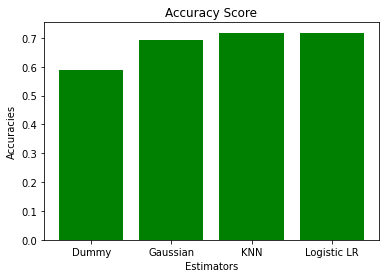

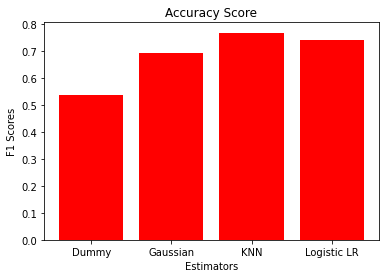

In [63]:
# Accuracy Score
accuracies = [opt_accuracy_dc, opt_accuracy_gnb, opt_accuracy_knn, opt_accuracy_lr]
plt.bar(estimators, accuracies, color='green')
plt.xlabel("Estimators")
plt.ylabel("Accuracies")
plt.title("Accuracy Score")
plt.show()

# F1 Score
f1_scores = [opt_f1_dc, opt_f1_gnb, opt_f1_knn, opt_f1_lr]
plt.bar(estimators, f1_scores, color='red')
plt.xlabel("Estimators")
plt.ylabel("F1 Scores")
plt.title("Accuracy Score")
plt.show()

## **Αποτελέσματα και συμπεράσματα**
### Πίνακας Markdown
| Estimator           | Accuracy | Μεταβολή Acc. | Train+Predict Time | F1 Score | Μεταβολή F1 score | Train+Predict Time |
|---------------------|----------|---------------|--------------------|----------|-------------------|--------------------|
| Dummy Classifier    | 59%      | +0            | 2.43sec            | 54%      | +10.2             | 1.0sec             |
| Gaussian NB         | 69%      | +4.9          | 1.19sec            | 69%      | +8.22             | 1.0sec             |
| K-Nearest Neighbors | 72%      | +10.46        | 48.7sec            | 77%      | +21.83            | 49.0sec            |
| Logistic Regression | 72%      | +10.46        | 8.12sec            | 74%      | +18.9             | 8.1sec             |

### Bar Plot
Accura

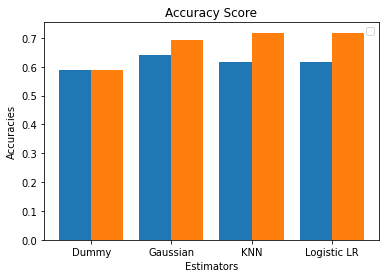

In [71]:
acc = [accuracy_dc, accuracy_gnb, accuracy_knn, accuracy_lr]
acc_opt = [opt_accuracy_dc, opt_accuracy_gnb, opt_accuracy_knn, opt_accuracy_lr]
  
X_axis = np.arange(len(acc))
  
plt.bar(X_axis - 0.2, acc, 0.4, label = '')
plt.bar(X_axis + 0.2, acc_opt, 0.4, label = '')
  
plt.xticks(X_axis, estimators)
plt.xlabel("Estimators")
plt.ylabel("Accuracies")
plt.title("Accuracy Score")
plt.legend()
plt.show()

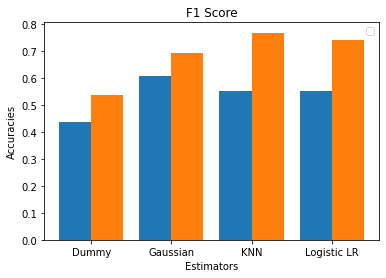

In [73]:
f1 = [f1_dc, f1_gnb, f1_knn, f1_lr]
f1_opt = [opt_f1_dc, opt_f1_gnb, opt_f1_knn, opt_f1_lr]
  
X_axis = np.arange(len(f1))
  
plt.bar(X_axis - 0.2, f1, 0.4, label = '')
plt.bar(X_axis + 0.2, f1_opt, 0.4, label = '')
  
plt.xticks(X_axis, estimators)
plt.xlabel("Estimators")
plt.ylabel("Accuracies")
plt.title("F1 Score")
plt.legend()
plt.show()

Παρατηρώντας τον πίνακα Markdown και το Bar Plot κάνουμε τις εξής διαπιστώσεις:
- Οι επιδόσεις των ταξινομητών έπειτα από τη βελτιστοποίηση είναι εμφανώς καλύτερες με τη μεγαλύτερη διαφορά να παρατηρείται στον ταξινομητή K-Nearest Neighbors.
- Η μεγαλύτερη χρονική διάρκεια εκτέλεσης του fit και του predict συμβαίνει στον ταξινομητή k-nearest neighbors όπου χρειάζεται και στις δύο εκπαιδεύσεις περίπου 50 δευτερόλεπτα συνολικά. Αυτό αποτελεί ένα σημαντικό μειονέκτημα του μοντέλου λαμβάνοντας υπόψη και τη μικρή διαφορά στις επιδόσεις του σε σχέση με τον ταξινομητή Logistic Regression ο οποίος χρειάζεται μόλις 8 δευτερόλεπτα για να εκπαιδευτεί. 
- Παρόλο που φαίνεται οριακά ο ταξινομητής K-Nearest-Neighbors να υπερτερεί ως προς τις επιδόσεις του, θα επιλέξουμε ως προτιμότερο μοντέλο για το συγκεκριμένο dataset τον ταξινομητή **Logistic Regression**. Αυτό διότι οι επιδόσεις είναι οριακά ίδιες με αυτές του knn αλλά σε πολύ ταχύτερο χρόνο! 